# Lab 5 PyTorch tutorial with junk removed

In [1]:
import os
import random
import gzip
import pickle
import zipfile
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading MNIST as example

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://figshare.com/ndownloader/files/25635053"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(
        f, encoding="latin-1"
    )

('x_train.shape', (50000, 784))
('y_train.shape', (50000,))


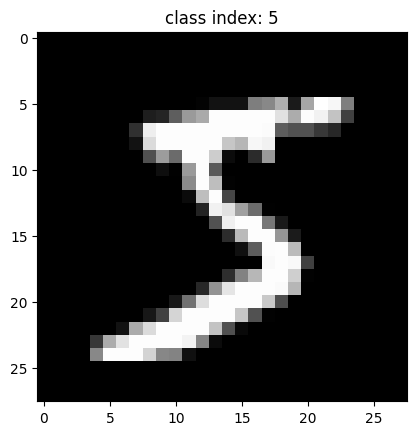

In [4]:
print(('x_train.shape',x_train.shape))
print(('y_train.shape',y_train.shape))

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.title('class index: ' + str(y_train[0]));

## Generic functions

In [5]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [6]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [7]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [9]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load data

### Loading MNIST as example

In [11]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://figshare.com/ndownloader/files/25635053"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL).content
        (PATH / FILENAME).open("wb").write(content)

In [12]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

('x_train.shape', (50000, 784))
('y_train.shape', (50000,))


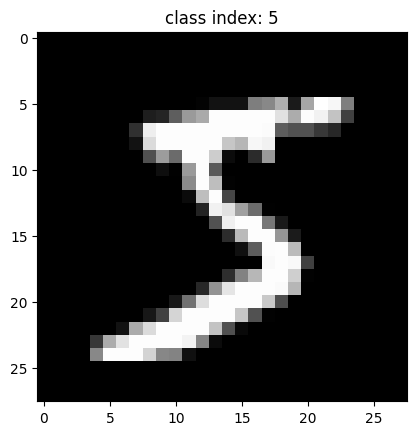

In [13]:
print(('x_train.shape',x_train.shape))
print(('y_train.shape',y_train.shape))

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.title('class index: ' + str(y_train[0]));

# Split data

In [14]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

bs = 64  # batch size
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [15]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

# Model

In [16]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

# Train

In [17]:
model.to(dev)
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [18]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.360838060951233
1 0.7305936695098877


# Load German traffic signs

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
import zipfile
import os

# Path to your ZIP file in Google Drive
zip_file_path = '/content/gdrive/MyDrive/German-traffic-signs/archive.zip'

# Create a directory to extract the contents if it doesn't exist
extract_path = '/content/gtsrb'
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['Test', 'train', 'Meta', 'meta', 'Meta.csv', 'test', 'Train.csv', 'Train', 'Test.csv']


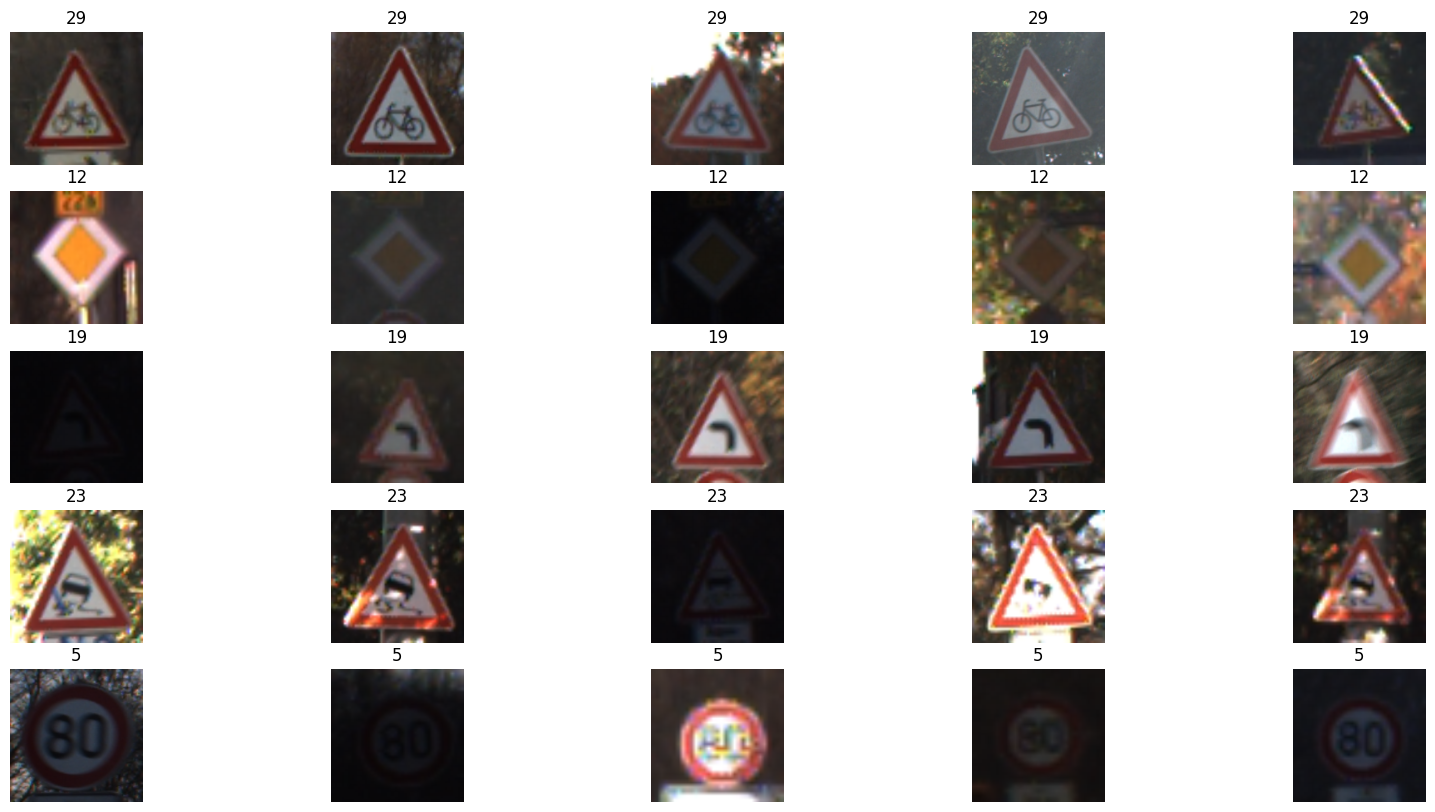

In [20]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the training data
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
])

# Load the training dataset
train_dataset = datasets.ImageFolder(
    root='/content/gtsrb/train',
    transform=transform
)

# Function to display images
def imshow(images, labels, classes):
    plt.figure(figsize=(20, 10)) # Adjust the size for better visibility
    for i in range(len(images)):
        ax = plt.subplot(5, 5, i + 1)  # Create a 5x5 grid
        plt.imshow(images[i].permute(1, 2, 0) / 2 + 0.5) # Unnormalize
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

# Function to get 5 images from 5 random classes
def get_images_from_random_classes(dataset, num_classes=5, images_per_class=5):
    images = []
    labels = []

    # Select random class indices
    class_indices = random.sample(range(len(dataset.classes)), num_classes)

    for class_index in class_indices:
        # Find all indices of images for the given class
        class_image_indices = [
            i for i, label in enumerate(dataset.targets)
            if label == class_index
        ]

        # Randomly select 5 images from the class (without replacement)
        selected_indices = random.sample(class_image_indices, images_per_class)

        for index in selected_indices:
            images.append(dataset[index][0])  # Get the image tensor
            labels.append(dataset[index][1])  # Get the class label

    return images, labels

# Get 5 images and labels from 5 random classes
images, labels = get_images_from_random_classes(
    train_dataset,
    num_classes=5,
    images_per_class=5
)

# Display the images and their class labels
imshow(images, labels, train_dataset.classes)